Train a SGAN using an appropriate image dataset to classify instances by using only fraction
of training examples and then compare the model’s classification accuracy to an equivalent
fully supervised model.

## Semi-Supervised GAN

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras import backend as K

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Dropout, Flatten, Input, Lambda, Reshape)
from keras.layers import LeakyReLU
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical

## DATASET

In [5]:
class Dataset:
    def __init__(self, num_labeled):

        # Number labeled examples to use for training
        self.num_labeled = num_labeled

        # Load the MNIST dataset
        (self.x_train, self.y_train), (self.x_test,
                                       self.y_test) = mnist.load_data()

        def preprocess_imgs(x):
            # Rescale [0, 255] grayscale pixel values to [-1, 1]
            x = (x.astype(np.float32) - 127.5) / 127.5
            # Expand image dimensions to width x height x channels
            x = np.expand_dims(x, axis=3)
            return x

        def preprocess_labels(y):
            return y.reshape(-1, 1)

        # Training data
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)

        # Testing data
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)

    def batch_labeled(self, batch_size):
        # Get a random batch of labeled images and their labels
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        # Get a random batch of unlabeled images
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0],
                                batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test

In [6]:
# Number of labeled examples to use (rest will be used as unlabeled)
num_labeled = 100

dataset = Dataset(num_labeled)

11490434/11490434 [==============================] - 0s 0us/step


In [7]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

## GENERATOR

In [8]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))

    return model

## DISCRIMINATOR

In [9]:
def build_discriminator_net(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Droupout
    model.add(Dropout(0.5))

    # Flatten the tensor
    model.add(Flatten())

    # Fully connected layer with num_classes neurons
    model.add(Dense(num_classes))

    return model

In [10]:
def build_discriminator_supervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    # Softmax activation, giving predicted probability distribution over the real classes
    model.add(Activation('softmax'))

    return model

In [11]:
def build_discriminator_unsupervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):
        # Transform distribution over real classes into a binary real-vs-fake probability
        prediction = 1.0 - (1.0 /
                            (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 'Real-vs-fake' output neuron defined above
    model.add(Lambda(predict))

    return model

## BUILD THE MODEL

In [12]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

## DISCRIMINATOR

In [13]:
# Core Discriminator network:
# These layers are shared during supervised and unsupervised training
discriminator_net = build_discriminator_net(img_shape)

# Build & compile the Discriminator for supervised training
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy',
                                 metrics=['accuracy'],
                                 optimizer=Adam())

# Build & compile the Discriminator for unsupervised training
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy',
                                   optimizer=Adam())

## GENERATOR

In [14]:
# Build the Generator
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator_unsupervised.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
# Note that we are using the Discriminator version with unsupervised output
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## TRAINING

In [15]:
supervised_losses = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get labeled examples
        imgs, labels = dataset.batch_labeled(batch_size)

        # One-hot encode labels
        labels = to_categorical(labels, num_classes=num_classes)

        # Get unlabeled examples
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # Train on real labeled examples
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)

        # Train on real unlabeled examples
        d_loss_real = discriminator_unsupervised.train_on_batch(
            imgs_unlabeled, real)

        # Train on fake examples
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)

        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))

        if (iteration + 1) % sample_interval == 0:

            # Save Discriminator supervised classification loss to be plotted after training
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy,
                   d_loss_unsupervised, g_loss))

## Train the Model and Inspect Output

In [16]:
# Set hyperparameters
iterations = 8000
batch_size = 32
sample_interval = 800

# Train the SGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step
5600 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000058]
1/1 [==============================] - 0s 27ms/step
6400 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000017]
1/1 [==============================] - 0s 29ms/step
7200 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000010]
1/1 [==============================] - 0s 29ms/step
8000 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000022]


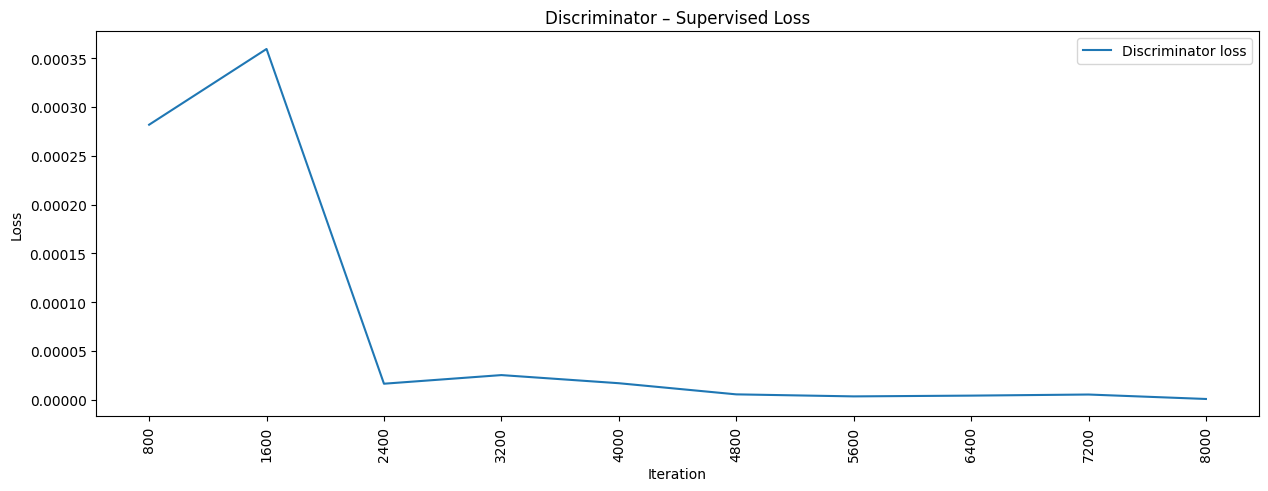

In [17]:
losses = np.array(supervised_losses)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

## SGAN Classifier – Training and Test Accuracy

In [18]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 6ms/step - loss: 0.0370 - accuracy: 0.9900
Training Accuracy: 99.00%


In [20]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 4ms/step - loss: 2.9964 - accuracy: 0.6088
Test Accuracy: 60.88%


## Fully-Supervised Classifier

In [21]:
# Fully supervised classifier with the same network architecture as the SGAN Discriminator
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [23]:
imgs, labels = dataset.training_set()

# One-hot encode labels
labels = to_categorical(labels, num_classes=num_classes)

# Train the classifier
training = mnist_classifier.fit(x=imgs,
                                y=labels,
                                batch_size=32,
                                epochs=30,
                                verbose=1)
losses = training.history['loss']
accuracies = training.history['accuracy']

Epoch 1/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 2/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 3/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 4/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 5/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 6/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 7/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 8/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 9/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 10/30
4/4 [==============================] - 0s 8ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 11/30
4/4 [======================

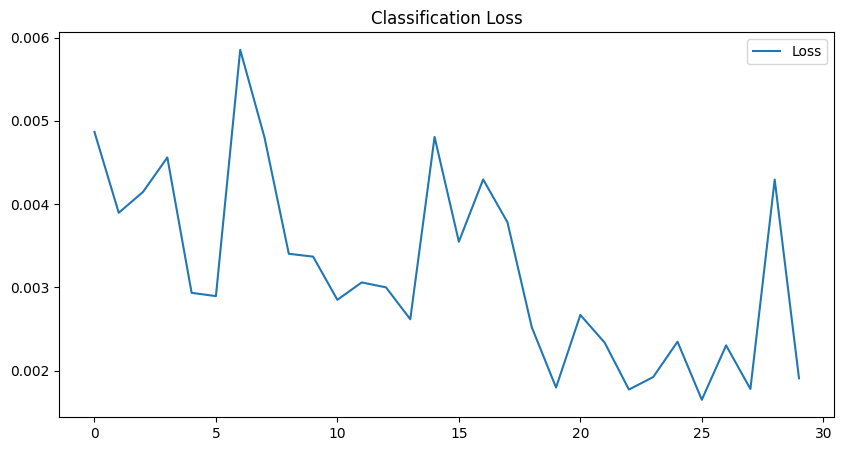

In [24]:
# Plot classification loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()

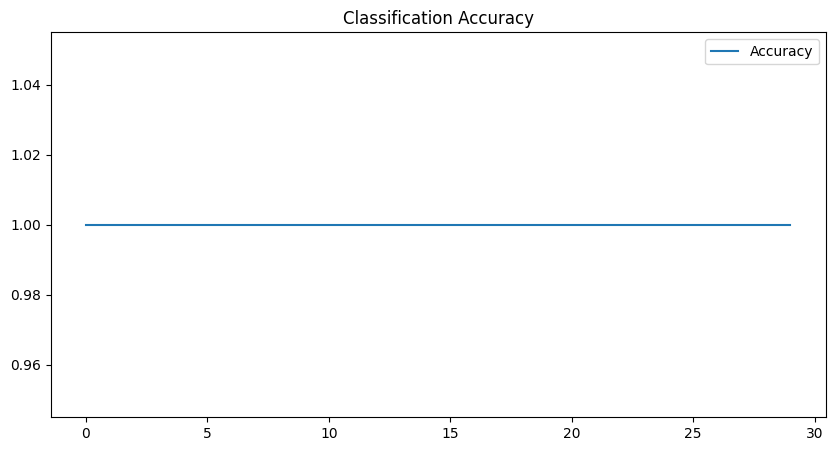

In [25]:
# Plot classification accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy")
plt.legend()

In [26]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 6ms/step - loss: 0.8062 - accuracy: 1.0000
Training Accuracy: 100.00%


In [27]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 4ms/step - loss: 1.5428 - accuracy: 0.6102
Test Accuracy: 61.02%
